- ### CSC 578 "Class Project", Part (A) Kaggle competition
- ### kaggle name: d.s
- ### Dongmin Sun

# 0. Data Pre-processing

In [1]:
# Import libraries

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

pd.set_option("display.max_columns", None)


# os.chdir("/Users/dongminsun/Desktop/578 final project/0. dataset")

> ## 0.1 Load Data

In [2]:
from pathlib import Path
import subprocess

DATA = 'data'
DATASET = 'Metro_Interstate_Traffic_Volume.csv'
# create data dir
Path(DATA).mkdir(parents=True, exist_ok=True)

# download and extract data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz'
subprocess.run(['curl', '-o', f'{DATA}/{DATASET}.gz', url])
subprocess.run(['gzip', '-d', f'{DATA}/{DATASET}.gz'])

CompletedProcess(args=['gzip', '-d', 'data/Metro_Interstate_Traffic_Volume.csv.gz'], returncode=0)

In [4]:
from google.colab import files
uploaded = files.upload()

import io
df = pd.read_csv(io.BytesIO(uploaded['Metro_Interstate_Traffic_Volume.csv']))
# Dataset is now stored in a Pandas Dataframe

#df = pd.read_csv(f'Metro_Interstate_Traffic_Volume.csv')
df.head(5)

Saving Metro_Interstate_Traffic_Volume.csv to Metro_Interstate_Traffic_Volume.csv


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [5]:
# deal with < date_time >
time_col = 'date_time'

df[time_col] = pd.to_datetime(df[time_col])
# sort dataframe by time
df = df.sort_values(time_col)

In [6]:
# check for missing values

df.isnull().sum()

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
traffic_volume         0
dtype: int64

In [7]:
# get the first and last timestamps
start, end = df.date_time.iloc[[0,-1]].values

# get a list of hourly timestamps in this range
full_range = pd.date_range(start, end, freq='H')

full_range.shape[0], full_range.shape[0]- df.shape[0]

(52551, 4347)

In [8]:
df.shape

(48204, 9)

In [9]:
# df = pd.DataFrame(full_range, columns=[time_col]).merge(df, on=time_col, how='outer')


In [10]:
df = df.set_index(time_col)


In [11]:
df.head(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
date_time,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918


> ## 0.2 Deal with Categorical Variables

- ### 0.2.1: weather_description

In [12]:
# One hot encode 
# weather_description

df['weather_description'].unique()

array(['scattered clouds', 'broken clouds', 'overcast clouds',
       'sky is clear', 'few clouds', 'light rain',
       'light intensity drizzle', 'mist', 'haze', 'fog',
       'proximity shower rain', 'drizzle', 'moderate rain',
       'heavy intensity rain', 'proximity thunderstorm',
       'thunderstorm with light rain', 'proximity thunderstorm with rain',
       'heavy snow', 'heavy intensity drizzle', 'snow',
       'thunderstorm with heavy rain', 'freezing rain', 'shower snow',
       'light rain and snow', 'light intensity shower rain', 'SQUALLS',
       'thunderstorm with rain', 'proximity thunderstorm with drizzle',
       'thunderstorm', 'Sky is Clear', 'very heavy rain',
       'thunderstorm with light drizzle', 'light snow',
       'thunderstorm with drizzle', 'smoke', 'shower drizzle',
       'light shower snow', 'sleet'], dtype=object)

In [13]:
dummies = pd.get_dummies(df['weather_description'], prefix='weather')
df[dummies.columns] = dummies

- ### 0.2.2: holiday

In [14]:
print(df['holiday'].unique())
dummies = pd.get_dummies(df['holiday'], prefix='holiday')
df[dummies.columns] = dummies

['None' 'Columbus Day' 'Veterans Day' 'Thanksgiving Day' 'Christmas Day'
 'New Years Day' 'Washingtons Birthday' 'Memorial Day' 'Independence Day'
 'State Fair' 'Labor Day' 'Martin Luther King Jr Day']


> ## 0.3 date_time - hourly / day / year

In [15]:
df.head(2)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,weather_SQUALLS,weather_Sky is Clear,weather_broken clouds,weather_drizzle,weather_few clouds,weather_fog,weather_freezing rain,weather_haze,weather_heavy intensity drizzle,weather_heavy intensity rain,weather_heavy snow,weather_light intensity drizzle,weather_light intensity shower rain,weather_light rain,weather_light rain and snow,weather_light shower snow,weather_light snow,weather_mist,weather_moderate rain,weather_overcast clouds,weather_proximity shower rain,weather_proximity thunderstorm,weather_proximity thunderstorm with drizzle,weather_proximity thunderstorm with rain,weather_scattered clouds,weather_shower drizzle,weather_shower snow,weather_sky is clear,weather_sleet,weather_smoke,weather_snow,weather_thunderstorm,weather_thunderstorm with drizzle,weather_thunderstorm with heavy rain,weather_thunderstorm with light drizzle,weather_thunderstorm with light rain,weather_thunderstorm with rain,weather_very heavy rain,holiday_Christmas Day,holiday_Columbus Day,holiday_Independence Day,holiday_Labor Day,holiday_Martin Luther King Jr Day,holiday_Memorial Day,holiday_New Years Day,holiday_None,holiday_State Fair,holiday_Thanksgiving Day,holiday_Veterans Day,holiday_Washingtons Birthday
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [16]:
df2 = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
df2.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [17]:
date_time = pd.to_datetime(df2.pop('date_time'), format='%Y-%m-%d %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)

day = 24*60*60
year = (365.2425)*day

#df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
#df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
#df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
#df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

day_sin = np.sin(timestamp_s * (2 * np.pi / day))
day_cos = np.cos(timestamp_s * (2 * np.pi / day))
year_sin = np.sin(timestamp_s * (2 * np.pi / year))
year_cos = np.cos(timestamp_s * (2 * np.pi / year))

In [18]:
hour_sin = np.sin(2*np.pi*(df.index.hour.values/24))
hour_cos = np.cos(2*np.pi*(df.index.hour.values/24))

Text(0.5, 1.0, 'Time of day signal')

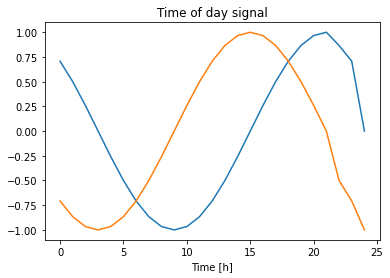

In [19]:
plt.plot(np.array(day_sin)[:25])
plt.plot(np.array(day_cos)[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

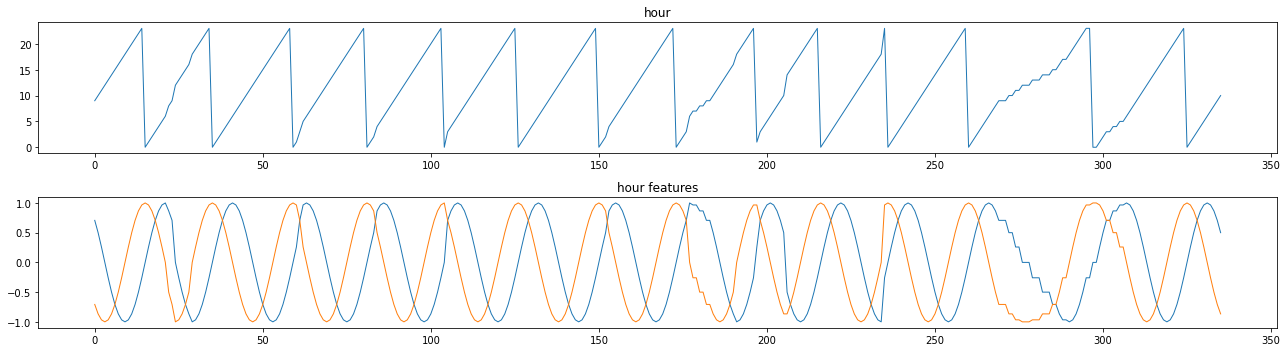

In [20]:
fig,axs = plt.subplots(2, 1, figsize=(18,5))
axs[0].plot(df.index.hour[:24*7*2],'-', lw=1)
axs[0].set_title('hour')
axs[1].plot(hour_sin[:24*7*2],'-', lw=1)
axs[1].plot(hour_cos[:24*7*2],'-', lw=1)
axs[1].set_title('hour features')
plt.tight_layout()

> ## 0.4 Split data

In [21]:
# drop the categorical vars
df = df.drop(['weather_main','weather_description','holiday'],axis=1)

In [22]:
test_start_time  = df.index[-1] - np.timedelta64(30*6,  'D')
valid_start_time = df.index[-1] - np.timedelta64(30*12, 'D')

In [23]:
ranges = {
    'train': (df.index[0], valid_start_time),
    'valid': (valid_start_time, test_start_time),
    'test':  (test_start_time, df.index[-1])
}

In [24]:
datasets = {}
time_to_index = lambda time: np.where(df.index == time)[0][0]

datasets['train'] = df.iloc[:time_to_index(valid_start_time)]
datasets['valid'] = df.iloc[time_to_index(valid_start_time):
                            time_to_index(test_start_time)]
datasets['test']  = df.iloc[time_to_index(test_start_time):]

for key,dataset in datasets.items():
    print(dataset.shape[0], key, 'rows in total.')

37763 train rows in total.
5153 valid rows in total.
5288 test rows in total.


In [25]:
df.shape

(48204, 55)

In [26]:
datasets['train'].shape[0]+datasets['valid'].shape[0]

42916

In [27]:
num_features = df.shape[1]
print(num_features)

55


> ## 0.5 Normalize the data

In [28]:
df=df.interpolate()

In [29]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]


In [30]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

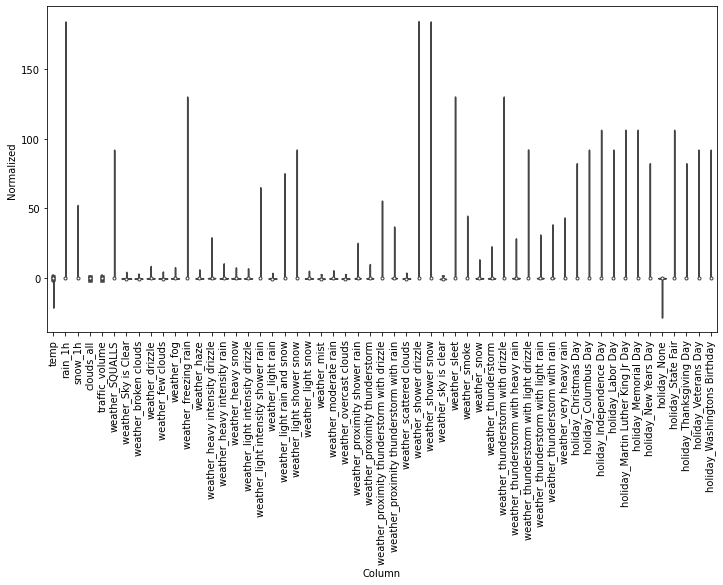

In [31]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# 1. Data windowing

> ## 1.1. Indexes and offsets

In [32]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [33]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['traffic_volume'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['traffic_volume']

In [34]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=3,
                     label_columns=['traffic_volume'])
w2

Total window size: 9
Input indices: [0 1 2 3 4 5]
Label indices: [8]
Label column name(s): ['traffic_volume']

> ## 1.2. Split

In [35]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [36]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 9, 55)
Inputs shape: (3, 6, 55)
labels shape: (3, 1, 1)


> ## 1.3 Plot

In [37]:
w2.example = example_inputs, example_labels


In [38]:
def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot


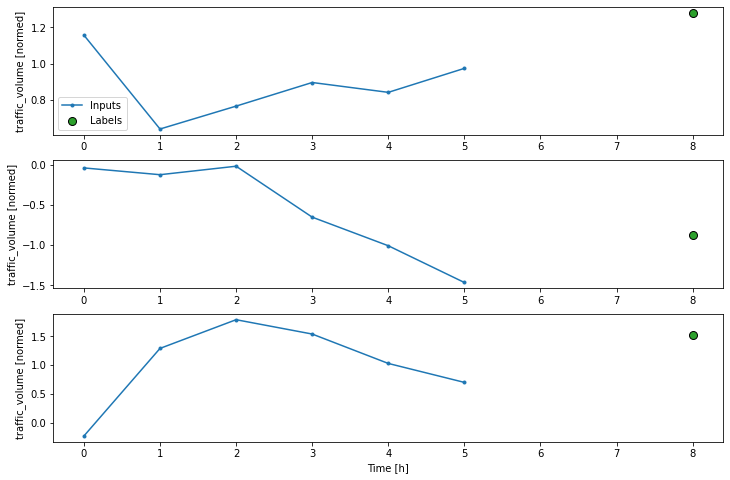

In [39]:
w2.plot()

In [40]:
df.columns

Index(['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume',
       'weather_SQUALLS', 'weather_Sky is Clear', 'weather_broken clouds',
       'weather_drizzle', 'weather_few clouds', 'weather_fog',
       'weather_freezing rain', 'weather_haze',
       'weather_heavy intensity drizzle', 'weather_heavy intensity rain',
       'weather_heavy snow', 'weather_light intensity drizzle',
       'weather_light intensity shower rain', 'weather_light rain',
       'weather_light rain and snow', 'weather_light shower snow',
       'weather_light snow', 'weather_mist', 'weather_moderate rain',
       'weather_overcast clouds', 'weather_proximity shower rain',
       'weather_proximity thunderstorm',
       'weather_proximity thunderstorm with drizzle',
       'weather_proximity thunderstorm with rain', 'weather_scattered clouds',
       'weather_shower drizzle', 'weather_shower snow', 'weather_sky is clear',
       'weather_sleet', 'weather_smoke', 'weather_snow',
       'weather_thunders

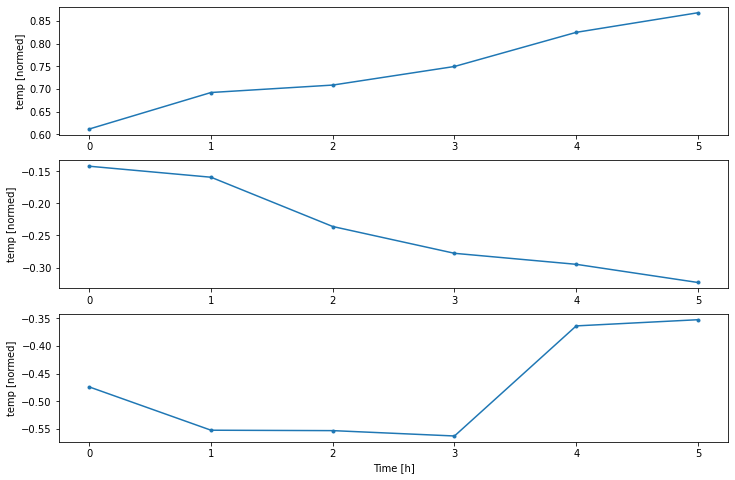

In [41]:
w2.plot(plot_col='temp')


> ## 1.4 Create tf.data.Datasets

In [42]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(data=data,targets=None,sequence_length=self.total_window_size,sequence_stride=1,shuffle=True,batch_size=32) 
    ds = ds.map(self.split_window)
    return ds

In [43]:
WindowGenerator.make_dataset = make_dataset

In [44]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    result = getattr(self, '_example', None)
    if result is None:
        result = next(iter(self.train))
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [45]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 55), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [46]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 55)
Labels shape (batch, time, features): (32, 1, 1)


> ## 1.5 Single step models

In [47]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['traffic_volume'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['traffic_volume']

for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

> ## 1.6 Models

>> ### 1.6.1 Baseline

In [48]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [49]:
baseline = Baseline(label_index=column_indices['traffic_volume'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

302/302 [==============================] - 1s 3ms/step - loss: 0.1410 - mean_absolute_error: 0.2456


In [50]:
wide_window = WindowGenerator(
    input_width=6, label_width=1, shift=3,
    label_columns=['traffic_volume'])

wide_window

Total window size: 9
Input indices: [0 1 2 3 4 5]
Label indices: [8]
Label column name(s): ['traffic_volume']

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

wide_window.plot(baseline)


>> ### 1.6.2 Linear Model

In [51]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

In [52]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

wide_window.plot(linear)


plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

> ## 1.7 Dense

dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

> ## 1.8 Multi-step dense

In [53]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['traffic_volume'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['traffic_volume']

conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

In [54]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [55]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 55)
Output shape: (32, 1, 1)


In [56]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

302/302 [==============================] - 1s 3ms/step - loss: 0.0693 - mean_absolute_error: 0.1823


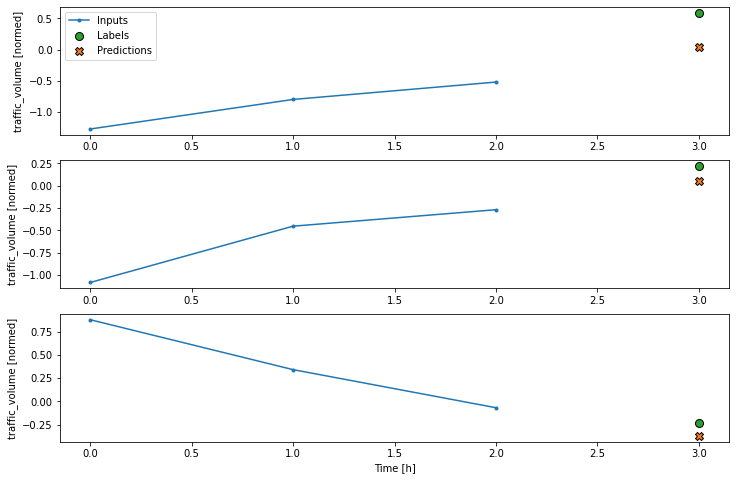

In [57]:
conv_window.plot(multi_step_dense)


In [58]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 6, 55)

InvalidArgumentError:Matrix size-incompatible: In[0]: [32,330], In[1]: [165,32] [Op:MatMul]


# 2. Recurrent neural network

In [59]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1)
])

In [60]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 6, 55)
Output shape: (32, 6, 1)


In [61]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

302/302 [==============================] - 1s 5ms/step - loss: 0.4079 - mean_absolute_error: 0.4818


In [62]:
hidden_size=[16,32,64]
layer_num=[1,2,3]
dropout=[True,False]

n=0
hyperparam_df=pd.DataFrame(columns=['hidden_size','layer_num','dropout','loss','mae'])
for hs in hidden_size:
    for ln in layer_num:
        for d in dropout:
            stucture=[]
            for i in range(ln):
                stucture.append(tf.keras.layers.LSTM(hs, return_sequences=True))
            if d:
                stucture.append(tf.keras.layers.Dropout(0.5))
            stucture.append(tf.keras.layers.Dense(units=1))
            lstm_model=tf.keras.models.Sequential(stucture)
            history = compile_and_fit(lstm_model, wide_window)
            val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
            hyperparam_df.loc[n]=[hs,ln,d,val_performance['LSTM'][0],val_performance['LSTM'][1]]
            n+=1

Epoch 1/20
1055/1055 [==============================] - 8s 8ms/step - loss: 0.9272 - mean_absolute_error: 0.8271 - val_loss: 0.7066 - val_mean_absolute_error: 0.7146
Epoch 2/20
1055/1055 [==============================] - 8s 8ms/step - loss: 0.7700 - mean_absolute_error: 0.7365 - val_loss: 0.6426 - val_mean_absolute_error: 0.6749
Epoch 3/20
1055/1055 [==============================] - 8s 8ms/step - loss: 0.7095 - mean_absolute_error: 0.6963 - val_loss: 0.5907 - val_mean_absolute_error: 0.6362
Epoch 4/20
1055/1055 [==============================] - 8s 7ms/step - loss: 0.6732 - mean_absolute_error: 0.6711 - val_loss: 0.5565 - val_mean_absolute_error: 0.6120
Epoch 5/20
1055/1055 [==============================] - 8s 7ms/step - loss: 0.6526 - mean_absolute_error: 0.6568 - val_loss: 0.5382 - val_mean_absolute_error: 0.6002
Epoch 6/20
1055/1055 [==============================] - 8s 7ms/step - loss: 0.6353 - mean_absolute_error: 0.6451 - val_loss: 0.5202 - val_mean_absolute_error: 0.5858
Epoc

In [63]:
hyperparam_df

,hidden_size,layer_num,dropout,loss,mae
0,16,1,True,0.466821,0.544846
1,16,1,False,0.436590,0.509447
2,16,2,True,0.418668,0.496577
3,16,2,False,0.418199,0.490630
4,16,3,True,0.398937,0.477900
5,16,3,False,0.401718,0.473567
6,32,1,True,0.445683,0.524484
7,32,1,False,0.414603,0.487897
8,32,2,True,0.407023,0.479702
9,32,2,False,0.378632,0.452848


ValueError: ignored

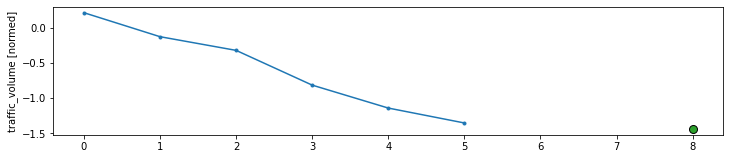

In [64]:
wide_window.plot(lstm_model)


> ## 2.1 Performance

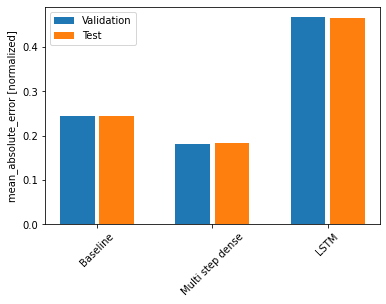

In [68]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

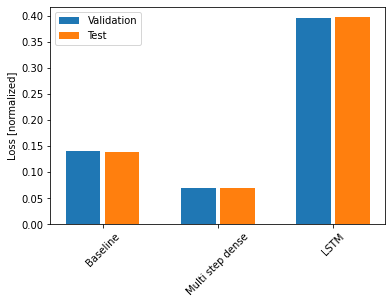

In [67]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'Loss'
metric_index = lstm_model.metrics_names.index('loss')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('Loss [normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [69]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.2440
Multi step dense: 0.1837
LSTM        : 0.4663


In [70]:
pred=lstm_model.predict(wide_window.test)

In [71]:
pred.shape

(4813, 6, 1)

In [72]:
pred[:,-1,:]

array([[ 1.2640872 ],
       [ 0.93958086],
       [-1.363042  ],
       ...,
       [-1.3548554 ],
       [ 0.87663   ],
       [-0.30692306]], dtype=float32)

In [73]:
origianl_pred=pred[:,-1,:].flatten()*train_std['traffic_volume']+train_mean['traffic_volume']

In [74]:
origianl_pred_df=pd.DataFrame(columns=['prediction'],data=origianl_pred)

In [75]:
origianl_pred_df.index=range(n-origianl_pred_df.shape[0],n)

In [76]:
origianl_pred_df.index.name='id'

In [77]:
origianl_pred_df=origianl_pred_df.reset_index()

In [78]:
origianl_pred_df.to_csv('submission.csv')

In [79]:
origianl_pred_df

,id,prediction
0,-4795,5757.985352
1,-4794,5111.687988
2,-4793,525.708496
3,-4792,3730.882324
4,-4791,1159.612061
...,...,...
4808,13,800.348633
4809,14,682.436523
4810,15,542.013184
4811,16,4986.312988


> ## 2.2 Multi-output models

In [80]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 55)
Labels shape (batch, time, features): (32, 24, 55)


>> ### 2.2.1 Base

In [81]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [82]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

301/301 [==============================] - 1s 3ms/step - loss: 2.3866 - mean_absolute_error: 0.1278


>> ### 2.2.2 Dense

In [83]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

302/302 [==============================] - 1s 4ms/step - loss: 1.2825 - mean_absolute_error: 0.1590


>> ### 2.2.3 RNN

In [84]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

301/301 [==============================] - 2s 6ms/step - loss: 1.2927 - mean_absolute_error: 0.1683

CPU times: user 1min 47s, sys: 11.6 s, total: 1min 58s
Wall time: 1min 15s


>> ### 2.2.4 Advanced: Residual connections

In [85]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [86]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

301/301 [==============================] - 2s 6ms/step - loss: 1.8916 - mean_absolute_error: 0.2101

CPU times: user 8min 25s, sys: 55 s, total: 9min 20s
Wall time: 5min 48s


>> ### 2.2.5 Performance (multi-output models.)

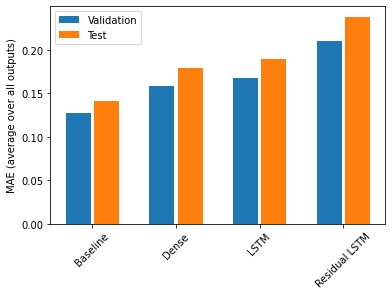

In [87]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [88]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1409
Dense          : 0.1789
LSTM           : 0.1900
Residual LSTM  : 0.2381


> ## 2.3 Multi-step models

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

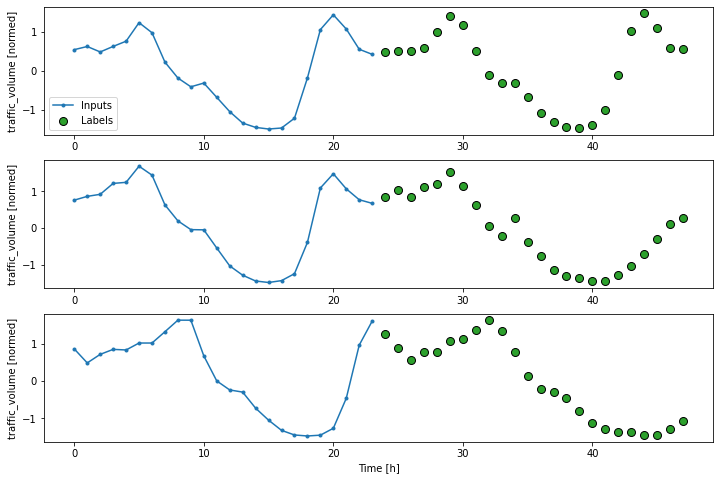

In [89]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

> ## 2.4 Baselines

300/300 [==============================] - 1s 4ms/step - loss: 2.6406 - mean_absolute_error: 0.1776


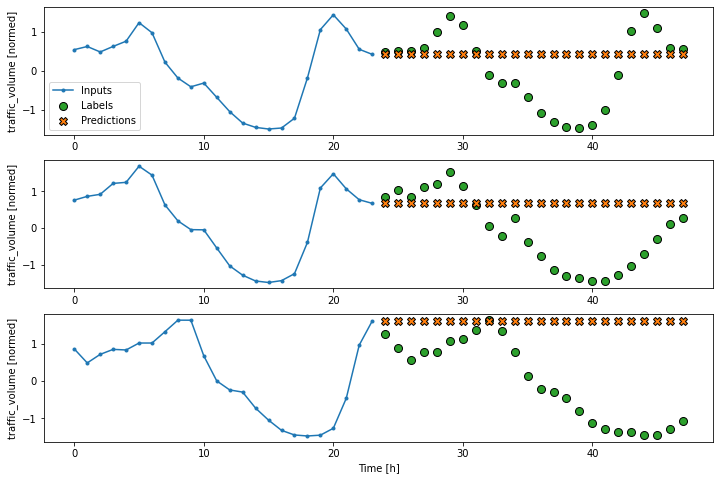

In [90]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

300/300 [==============================] - 1s 4ms/step - loss: 2.7098 - mean_absolute_error: 0.1816


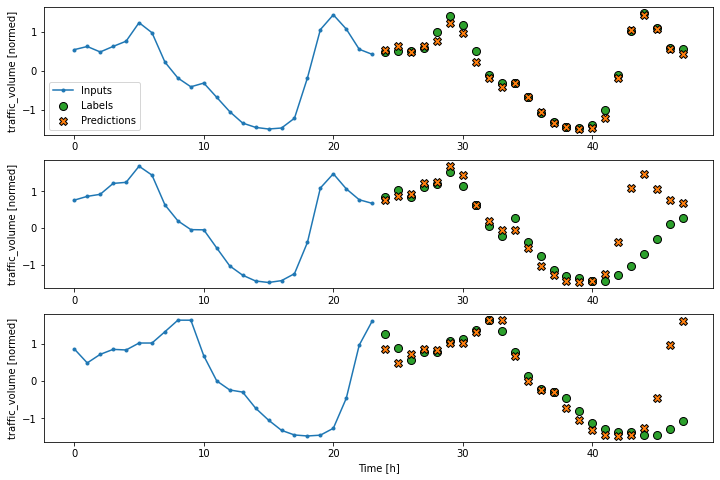

In [91]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

> ## 2.5 Single-shot models

>> ### 2.5.1 Linear

300/300 [==============================] - 1s 5ms/step - loss: 1.3726 - mean_absolute_error: 0.1915


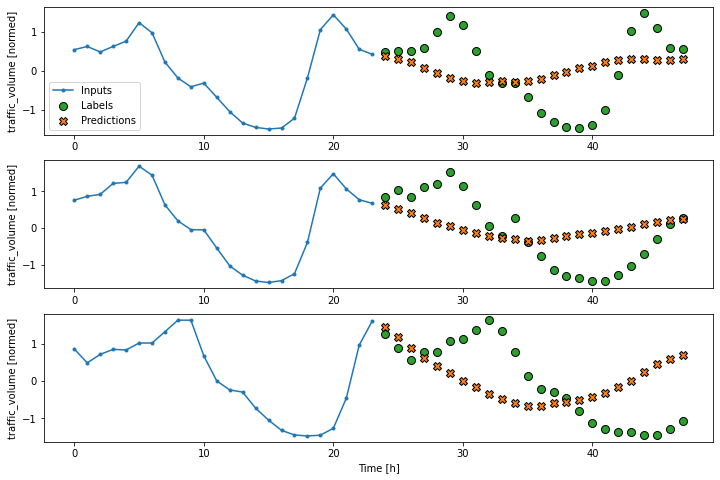

In [92]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

>> ### 2.5.3 Dense

300/300 [==============================] - 2s 7ms/step - loss: 2.0988 - mean_absolute_error: 0.2121


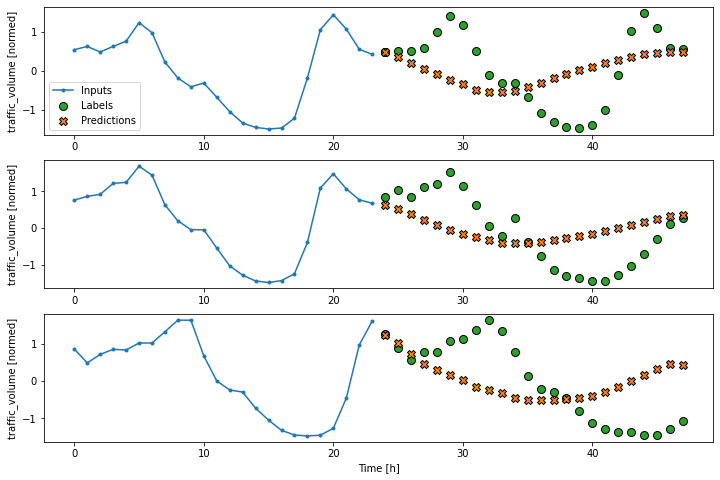

In [93]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

>> ### 2.5.4 RNN

300/300 [==============================] - 2s 7ms/step - loss: 1.3577 - mean_absolute_error: 0.1933


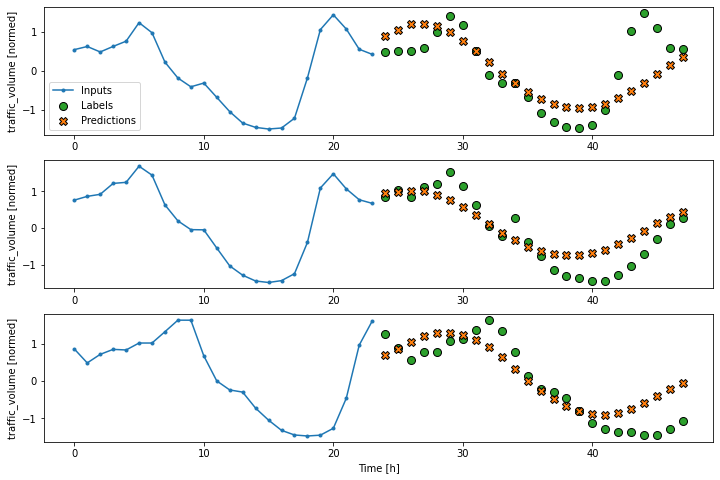

In [94]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

> ## 2.6 Advanced: Autoregressive model

>> ### 2.6.1 RNN

In [95]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [96]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [97]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 55])

In [98]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [99]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)


Output shape (batch, time, features):  (32, 24, 55)


300/300 [==============================] - 3s 8ms/step - loss: 1.3598 - mean_absolute_error: 0.1959


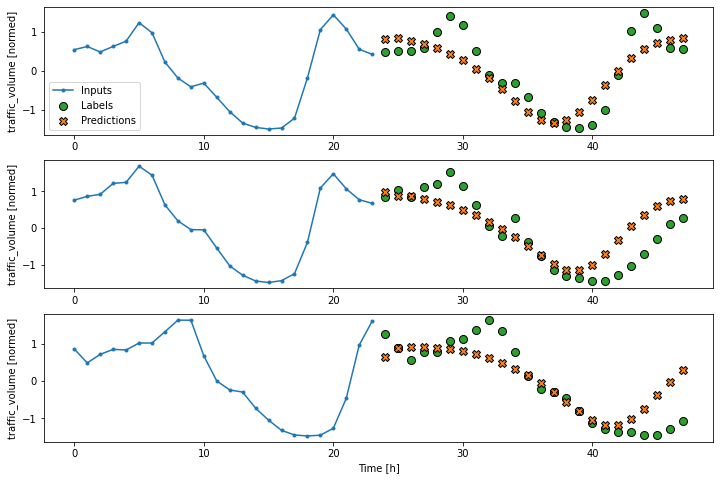

In [100]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

> ## 2.7 Performance

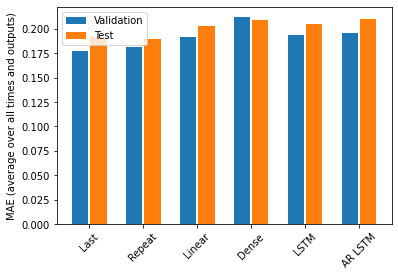

In [101]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()


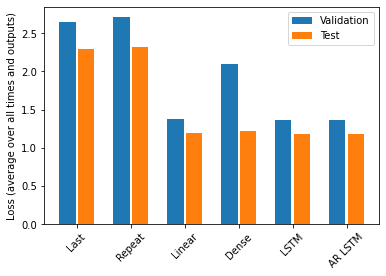

In [104]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'Loss'
metric_index = lstm_model.metrics_names.index('loss')
val_loss = [v[metric_index] for v in multi_val_performance.values()]
test_loss = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_loss, width, label='Validation')
plt.bar(x + 0.17, test_loss, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'Loss (average over all times and outputs)')
_ = plt.legend()

In [102]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.1914
Repeat  : 0.1893
Linear  : 0.2026
Dense   : 0.2093
LSTM    : 0.2054
AR LSTM : 0.2098
